In [25]:
import pandas as pd

import gurobipy as gp

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

In [26]:
df = pd.read_csv('price_demand_data.csv')
df.head()

,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002


In [27]:
lr = LinearRegression()
#fitting the model
lr.fit(df[['price']],df['demand'])

# residuals
res = df['demand'] - lr.predict(df[['price']])
beta1 = lr.coef_[0]
beta0 = lr.intercept_
print(beta0, beta1)

1924.7175435291088 -1367.7125241625981


In [28]:
price = 1

demand = beta0 +  price*beta1 + res
demand

0     351.385626
1     579.520247
2     472.219630
3     448.937249
4     673.748994
         ...    
94    498.802628
95    669.103245
96    441.708501
97    858.354250
98    601.448378
Name: demand, Length: 99, dtype: float64

# LP

$$ obj - max (1/n\sum_{i=1}^n (pD_i - qc -t(q- D_i)^+ -g(D_i - q)^+))$$

$$ h_i \le - qc -t(q- D_i) $$ 
$$ h_i \le - qc -g(D_i - q) $$

p=1, c=0.5, g=0.75, and t=0.15

$$ h_i \le pD_i - cq -t(q - D_i)  $$
$$ (c+t)q + h_i \le (p+t)D_i $$

$$ h_i \le pD_i- cq -g(D_i - q) $$
$$ (c-g)q + h_i \le (p-g)D_i $$

In [29]:
days = len(demand)
p = 1
c = 0.5
g = 0.75
t = 0.15

obj = np.array([0] + [1/days] * days)

# We are initializing the constraint matrix
eq = days*2
var = 1 + days
A = np.zeros((eq, var))                    
b = np.zeros(eq)
sense = np.array(['<'] * eq )

for i in range(days):
    
    # eq 1
    A[2*i,0] = (c+t)
    A[2*i,i+1]=1
    b[2*i] = (p+t)*demand[i]
    
    # eq 2
    A[2*i+1,0] = (c-g)
    A[2*i+1,i+1]=1
    b[2*i+1] = (p-g)*demand[i]

lb = [0] + [-np.inf]*days
    
print(obj)

for i in range(eq):
    print(A[i,], sense[i], b[i])

[0.         0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.0101

  0.    0.    0.    0.  ] < 137.765687862439
[0.65 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.  ] < 608.9377984737878
[-0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    

In [30]:
opModel = gp.Model()

opModX = opModel.addMVar(len(obj), lb = lb)

opModCon = opModel.addMConstrs(A, opModX, sense, b)
opModel.setMObjective(None, obj, 0, sense=gp.GRB.MAXIMIZE)

opModel.Params.OutputFlag = 0
opModel.optimize()  

print("optimal profit", opModel.objVal)
print("optimal quantity to produce", opModX.x[0])

optimal profit 231.4836666471413
optimal quantity to produce 471.8653795908935


# QP

$$ obj fxn= max (1/n\sum_{i=1}^n (p\beta_0 + \beta_1p^2 + \epsilon_ip - qc -t(q- D_i)^+ -g(D_i - q)^+))$$

$$ obj fxn= max (p\beta_0 + \beta_1p^2 + \hat\epsilon_ip+ 1/n\sum_{i=1}^n h_i)$$
where $ \hat\epsilon = 1/n\sum_{i=1}^n \epsilon_i$ 

s.t.
$$ h_i \le - qc -t(q- D_i) $$
$$ h_i \le - qc -g(D_i - q) $$

restructuring above equations, we get 

$$ h_i \le - qc -t(q- (\beta_0 + \beta_1p + \epsilon_i)) $$
$$ h_i + (-t\beta_1)p + (c+t)q\le t(\epsilon_i + \beta_0) $$

$$ h_i \le - qc -g(\beta_0 + \beta_1p + \epsilon_i - q) $$
$$ h_i + (g\beta_1)p + (c-g)q\le -g(\epsilon_i + \beta_0) $$

In [31]:
p = 1
c = 0.5
g = 0.75
t = 0.15

lin = np.array([beta0] + [0] + [1/days] * days)

sigma = np.zeros(shape = (len(lin), len(lin)))
sigma[0,0] = beta1

# We are initializing the constraint matrix
eq = days*2
var = 2 + days
A = np.zeros((eq, var))                    
b = np.zeros(eq)
sense = np.array(['<'] * eq )

for i in range(days):
    # eq 1
    A[2*i,0] = -t*beta1 # p
    A[2*i,1] = c+t      # q
    A[2*i,i+2]=1        # hi
    b[2*i] = t*(res[i]+beta0)
    
    # eq 2
    A[2*i+1,0] = g*beta1  # p
    A[2*i+1,1] = c-g      # q
    A[2*i+1,i+2]=1        # hi
    b[2*i+1] = -g*(res[i]+beta0)

lb = [0]*2 + [-np.inf]*days
    
print(lin)

for i in range(eq):
    print(A[i,], sense[i], b[i])

[1.92471754e+03 0.00000000e+00 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.010101

  0.00000000e+00] < -1526.7373295346315
[205.15687862   0.65         0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   1.           0.           0. 

   0.        ] < 279.9772728455603
[-1.02578439e+03 -2.50000000e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000

In [32]:
qModel = gp.Model()
opMod_x = qModel.addMVar(var, lb = lb)
opMod_con = qModel.addMConstrs(A, opMod_x, sense, b)
qModel.setMObjective(sigma, lin, 0, sense=gp.GRB.MAXIMIZE)

qModel.Params.OutputFlag = 0
qModel.optimize()  

print("Optimal Profit", qModel.objVal)
print("Price", qModel.x[0])
print("Quanity", qModel.x[1])

Optimal Profit 234.42493487740035
Price 0.9536264966232567
Quanity 535.2910012836912


# QP - Rerunning the code

In [33]:
# resampling the demand
temp_df = df.sample(len(df), replace=True).reset_index(drop=True)

lr = LinearRegression()
lr.fit(temp_df[['price']],temp_df['demand'])
res = temp_df['demand'] - lr.predict(temp_df[['price']])
beta1 = lr.coef_[0]
beta0 = lr.intercept_

p = 1
c = 0.5
g = 0.75
t = 0.15

lin = np.array([beta0] + [0] + [1/days] * days)

sigma = np.zeros(shape = (len(lin), len(lin)))
sigma[0,0] = beta1

# We are initializing the constraint matrix
eq = days*2
var = 2 + days
A = np.zeros((eq, var))                    
b = np.zeros(eq)
sense = np.array(['<'] * eq )

for i in range(days):
    A[2*i,0] = -t*beta1 # p
    A[2*i,1] = c+t      # q
    A[2*i,i+2]=1        # hi
    b[2*i] = t*(res[i]+beta0)
    
    A[2*i+1,0] = g*beta1  # p
    A[2*i+1,1] = c-g      # q
    A[2*i+1,i+2]=1        # hi
    b[2*i+1] = -g*(res[i]+beta0)

lb = [0]*2 + [-np.inf]*days

qModel = gp.Model()
opMod_x = qModel.addMVar(var, lb = lb)
opMod_con = qModel.addMConstrs(A, opMod_x, sense, b)
qModel.setMObjective(sigma, lin, 0, sense=gp.GRB.MAXIMIZE)

qModel.Params.OutputFlag = 0
qModel.optimize()  

print("Optimal Profit", qModel.objVal)
print("Price", qModel.x[0])
print("Quanity", qModel.x[1])

Optimal Profit 235.90622746420263
Price 0.9614451966127756
Quanity 516.760038224459


# QP - simulation

In [34]:
profit = []
quantity = []
price = []

p = 1
c = 0.5
g = 0.75
t = 0.15
for i in range(100):
    temp_df = df.sample(len(df), replace=True).reset_index(drop=True)

    lr = LinearRegression()
    lr.fit(temp_df[['price']],temp_df['demand'])
    res = temp_df['demand'] - lr.predict(temp_df[['price']])
    beta1 = lr.coef_[0]
    beta0 = lr.intercept_

    lin = np.array([beta0] + [0] + [1/days] * days)

    sigma = np.zeros(shape = (len(lin), len(lin)))
    sigma[0,0] = beta1

    # We are initializing the constraint matrix
    eq = days*2
    var = 2 + days
    A = np.zeros((eq, var))                    
    b = np.zeros(eq)
    sense = np.array(['<'] * eq )

    for i in range(days):
        A[2*i,0] = -t*beta1 # p
        A[2*i,1] = c+t      # q
        A[2*i,i+2]=1        # hi
        b[2*i] = t*(res[i]+beta0)

        A[2*i+1,0] = g*beta1  # p
        A[2*i+1,1] = c-g      # q
        A[2*i+1,i+2]=1        # hi
        b[2*i+1] = -g*(res[i]+beta0)

    lb = [0]*2 + [-np.inf]*days

    qModel = gp.Model()
    opMod_x = qModel.addMVar(var, lb = lb)
    opMod_con = qModel.addMConstrs(A, opMod_x, sense, b)
    qModel.setMObjective(sigma, lin, 0, sense=gp.GRB.MAXIMIZE)

    qModel.Params.OutputFlag = 0
    qModel.optimize()  

    profit = profit + [qModel.objVal]
    price = price + [qModel.x[0]]
    quantity = quantity + [qModel.x[1]]

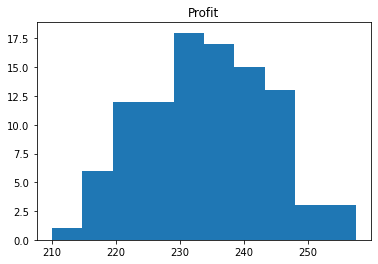

In [35]:
plt.hist(profit)
plt.title("Profit")
plt.show()

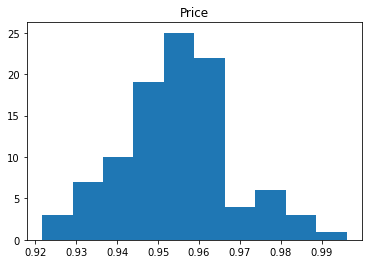

In [36]:
plt.hist(price)
plt.title("Price")
plt.show()

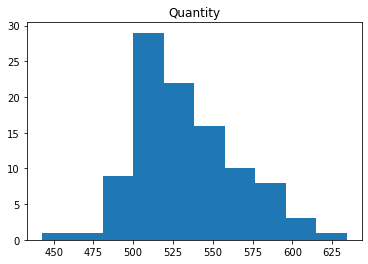

In [37]:
plt.hist(quantity)
plt.title("Quantity")
plt.show()

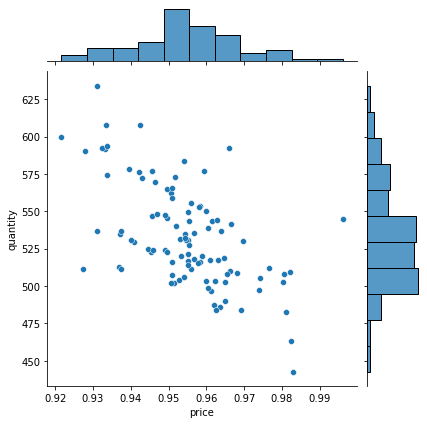

In [40]:
sns.jointplot(data = pd.DataFrame({
    'price':price,
    'quantity':quantity,
    'profit':profit
}),
              x = 'price', y = 'quantity')
plt.show()

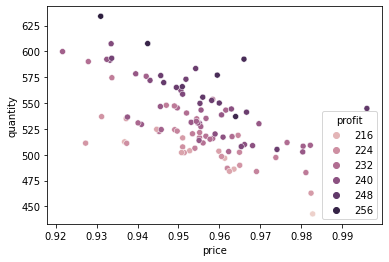

In [42]:
sns.scatterplot(data = pd.DataFrame({
    'price':price,
    'quantity':quantity,
    'profit':profit
}),
              x = 'price', y = 'quantity', hue = 'profit')
plt.show()